In [1]:
#basic settings and imports
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import pandas as pd
import math
import os
import astropy.units as u
from astropy.cosmology import LambdaCDM
from astropy.coordinates import SkyCoord
from scipy import stats
from scipy.stats import norm

cosmo = LambdaCDM(H0=100, Ode0=.7,Om0=0.3)

#this 'magic' matplotlib command tells iPython to show any figures in this notebook, 
#rather than a separate window or saving them in separate files.
%matplotlib inline

#These commands help python remember how to format my figures so that they look nice
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

In [18]:
#Functions
coeff10r = -0.196478  # Westra et al 2010 Table A21 K_r(z)
coeff20r = -5.4512 
coeff30r = 7.81183 
coeff11r = 3.11481 
coeff21r = -6.547 
coeff31r = 8.41136 
coeff12r = 0.486552 
coeff22r = 1.09495 
coeff32r = -3.05571 
coeff13r = -1.12639 
coeff23r = 2.90943 
coeff33r = -2.2226 

coeff10g = 0.184129  # Westra et al 2010 Table A20 K_g(z)
coeff20g = 0.112299 
coeff30g = -2.37339 
coeff11g = 1.00938 
coeff21g = -6.17196 
coeff31g = 15.3331 
coeff12g = 5.40158 
coeff22g = -7.21778 
coeff32g = -1.95179 
coeff13g = -2.41043 
coeff23g = 4.89703 
coeff33g = -2.36049 

c=3*10**5

labels=['Mr','\u03C3','\u0394\u03C3\u208A','\u0394\u03C3\u208B']

def dispersion(vel,err,mag,delV=1,avgV=1):
    
    data=[]
    
    ##This will calculate each dispersion of the array from Danese 1979
    for i in range(len(vel)):

        c=3*10**5
        df=(len(vel[i])-1)
        vbar= np.average(vel[i])
        eczbar=np.average(err[i])

        vel1= (vel[i]- vbar)/(1+vbar/c)
        if not(delV == 1):
            vel1= delV
            vbar= avgV
        
        velDis= sum(vel1**2/df) - (eczbar**2/(1+vbar/c)**2 )
        
        interval= stats.chi2.interval(.68,df)
        deltastar2= (eczbar)**2 /((1+vbar/c)**2)

        temp=[np.average(mag[i])]
        temp.append(np.sqrt(velDis))
        temp.append(np.sqrt((np.sqrt(df/interval[1])-1)**2 *velDis + deltastar2*(1+deltastar2/(2*velDis))/(df+1)))
        temp.append(np.sqrt((np.sqrt(df/interval[0])-1)**2 *velDis + deltastar2*(1+deltastar2/(2*velDis))/(df+1)))
        data.append(temp)
         
    return data

##This is a function taken from stack exchange that splits a list into n-equal parts
def chunkIt(seq, num):
    
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    return out

def cluster(i):

    #Each of the clusters are imported so that i can run through each of them for my analysis
    if i==1:
        cz, ecz, g,r, mem, dist = np.loadtxt(os.getcwd()+"\Data\comaallzad.tab.010.q25mem.tab", usecols=(2,3,5,6,9,10), skiprows=2, unpack=True)
        name='Coma'
    elif i==2:
        cz, ecz, g,r, mem, dist = np.loadtxt(os.getcwd()+"\Data\\a2069newad.mem.dat", usecols=(2,3,5,6,10,11), unpack=True)
        name='a2069'
        g = g[mem == 1]
        r = r[mem == 1]
        cz = cz[mem ==1]
        ecz = ecz[mem == 1]
        dist = dist[mem == 1]
        print(name,' Using a membership cut')        
    elif i==3:
        cz, ecz, g,r, mem, dist = np.loadtxt(os.getcwd()+"\Data\\a2219newad.mem.dat", usecols=(2,3,5,6,10,11), unpack=True)
        name='a2219'
        g = g[mem == 1]
        r = r[mem == 1]
        cz = cz[mem ==1]
        ecz = ecz[mem == 1]
        dist = dist[mem == 1]
        print(name,' Using a membership cut')
    elif i==4:
        cz, ecz, g,r, mem, dist = np.loadtxt(os.getcwd()+"\Data\\rxj1720newad.mem.dat", usecols=(2,3,5,6,10,11), unpack=True)    
        name='rxj1720'
        g = g[mem == 1]
        r = r[mem == 1]
        cz = cz[mem ==1]
        ecz = ecz[mem == 1]
        dist = dist[mem == 1]
        print(name,' Using a membership cut')        
    elif i==5:
        cz, ecz, g,r = np.loadtxt(os.getcwd()+"\Data\\a2029sohn17memphot.tab", usecols=(2,3,13,14),skiprows=2, unpack=True)    
        ra,dec= np.loadtxt(os.getcwd()+"\Data\\a2029sohn17memphot.tab", usecols=(0,1),skiprows=2, unpack=True)

        c1=SkyCoord(np.median(ra),np.median(dec),unit=('deg'))
        c2=SkyCoord(ra,dec,unit=('deg'))
        sep=c1.separation(c2)
        dist=sep.deg
        
        name='a2029'
    return cz, ecz, g, r, dist,name

##Function of sorts that will find the indexes of members of clusters (used for Red Blue split)
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]

'the next four functions are used to calculate the overall dispersion, binned dispersion and brightest member dispersion'
def membership():
    pass

def totalDis(r,cz,ecz):
    
    ##3 different approaches in general:
    #the file is already member cut (so nothing done)
    #Cut list by the distance to the cluster center
    #File has membership already so just choose by that
   
    #because my dispersion does the list of dispersions i have to make the files be in lists first 
    '''I SHOULD CHANGE THIS'''
    normal = dispersion([cz],[ecz],[r])
    
    return np.array(normal)
    
    
    
#BBCD-BRIGHTNESS BIN CLUSTER DISPERSION
#takes in how many bins and the cluster information and gives a list of bins dispersions
def BBCD(Bins,r,cz,ecz):
    
    
    ##Same Membership options as the total dispersion, but now i need to sort the arguement so that i can bin all the data
    ##Velocity and errors to be ordered by magnitude in the r filter [magIndexDcut]
    magIndexDcut = np.argsort(r)
        
    
    
    #ChunkIt puts the data in bins in a list 
    velocities = chunkIt(cz[magIndexDcut],Bins)
    errors = chunkIt(ecz[magIndexDcut],Bins)
    magnitude=chunkIt(r[magIndexDcut],Bins)

    #all the data are in lists which are put in the dispersion function
    values = dispersion(velocities,errors,magnitude)
    
    return np.array(values)

def bright10(r,cz,ecz,dist=False,mem=False,brightest=10):

    magIndexDcut = np.argsort(r)
    
    #Puts the brightest of the data in a list to be put into the dispersion function
    velocities = [cz[magIndexDcut[:brightest]]]
    errors = [ecz[magIndexDcut[:brightest]]]
    magnitude=[r[magIndexDcut[:brightest]]]
    
    
    values = dispersion(velocities,errors,magnitude)
    
    return np.array(values)

def normalizer(normal,stacks):
    
    disp=stacks[:,1]/normal[0][1]
    uperrors=[np.sqrt((v/n)**2+(normal[0][2]/normal[0][1])**2) for n, v in zip(stacks[:,1], stacks[:,2])]
    downerrors=[np.sqrt((v/n)**2+(normal[0][3]/normal[0][1])**2) for n, v in zip(stacks[:,1], stacks[:,3])]
    
    final=np.column_stack([stacks[:,0],disp,uperrors,downerrors])
    
    return final

'Following two functions are used to display the results of the dispersion functions'
def plotMyCluster(bins,r,cz,ecz,brightest=10,tables=True):
    
    #finds the relevant dispersions for the cluster
    overall=totalDis(r,cz,ecz)
    values=BBCD(bins,r,cz,ecz)
    bright=bright10(r,cz,ecz,brightest=brightest)
    
    #uses normalizer to display and plot normalized dispersions for the clusters
    normed=normalizer(overall,np.vstack([bright[0],values]))
    
    if tables==True:
        display(pd.DataFrame(np.vstack([overall,bright,values]),index=['Total','Bright '+str(brightest) ,1,2,3,4,5],columns=labels))
        print('Normalized')
        display(pd.DataFrame(normed,index=['Bright '+str(brightest),1,2,3,4,5],columns=labels))

    #Plots all of the relevant clusters and then the brightest a different color
    plt.scatter(normed[:,0],normed[:,1],c='k',s=25,label='Binned Clusters')
    plt.scatter(normed[:,0][0],normed[:,1][0],c='r',s=25,label='Brightest '+str(brightest))
    
    plt.xlabel('Average r-Magnitude')
    plt.ylabel('Velocity Dispersion (km/s)')

    #plots each of the error bars ontop of the data
    for i in range(len(normed[:,0])):
        plt.errorbar(normed[:,0][i],normed[:,1][i],yerr=[[normed[:,2][i]],[normed[:,3][i]]],capsize=5,linewidth=1.5,color='k')
    plt.legend()
    
    
'To compare all the clusters we need to convert the magnitudes to a comparable scale'
#using Westra 2010 formulas we convert the magnitude and color
def restframe(cz,g,r):
    c=3* 10**5
    z0 = cz/c     
    
    #these coefficients used to calculate restframe magnitudes
    coeffr0 = coeff10r*z0 + coeff20r*z0**2 + coeff30r*z0**3 
    coeffr1 = coeff11r*z0 + coeff21r*z0**2 + coeff31r*z0**3 
    coeffr2 = coeff12r*z0 + coeff22r*z0**2 + coeff32r*z0**3 
    coeffr3 = coeff13r*z0 + coeff23r*z0**2 + coeff33r*z0**3 

    coeffg0 = coeff10g*z0 + coeff20g*z0**2 + coeff30g*z0**3 
    coeffg1 = coeff11g*z0 + coeff21g*z0**2 + coeff31g*z0**3 
    coeffg2 = coeff12g*z0 + coeff22g*z0**2 + coeff32g*z0**3 
    coeffg3 = coeff13g*z0 + coeff23g*z0**2 + coeff33g*z0**3 
    
    #to deal with the contamination in the data i used a value that would produce -inf magnitude
    for i in range(len(z0)):
        if z0[i]<=0:
            z0[i]=np.exp(999)
            
    #formulas in the paper to convert mine [converted from Dr. Rines' PERL code]   
    miappstarz0 = [22.44 + 3.36*math.log(i) + 0.273*(math.log(i))**2 - 0.0618*(math.log(i))**3 - 0.0227*(math.log(i))**4 for i in z0]
    riz0 = 0.7*z0 + 0.34
    mrappstarz0 = miappstarz0 + riz0 
    mrapptestz0 = mrappstarz0 + 1.5 
    gr = g-r
    kcorrectr = coeffr0 + coeffr1*gr + coeffr2*gr**2 + coeffr3*gr**3 
    kcorrectg = coeffg0 + coeffg1*gr + coeffg2*gr**2 + coeffg3*gr**3 
    
    
    rabs=np.array([i - 25 - 5*math.log(j)/math.log(10) - k for i,j,k in zip(r,cosmo.luminosity_distance(z0).value,kcorrectr)])
    
    
    grcorr = gr - kcorrectg + kcorrectr 
    tgr0 = -0.0236265*(rabs) + 0.296184 
    
    #corrected color and Mr are returned
    return rabs,grcorr


In [19]:
#example cluster used as a test of the functions
cz, ecz, g,r, dist,name=cluster(1)
print(name)
totalDis(r,cz,ecz)

Coma


array([[ 16.02647619, 672.86456811,  13.38764536,  14.24185547]])

,Mr,σ,Δσ₊,Δσ₋
Total,16.902858,782.413006,27.278812,30.480162
Bright 5,14.519600,315.819551,69.541751,213.486433
1,15.862658,776.876404,57.098973,73.352602
2,16.561616,842.931382,61.947437,79.584484
3,16.986644,748.552940,55.020502,70.680834
4,17.336329,813.182625,59.769148,76.781983
5,17.755365,736.817846,53.831450,69.032271


Normalized


,Mr,σ,Δσ₊,Δσ₋
Bright 5,14.519600,0.403648,0.222938,0.677098
1,15.862658,0.992924,0.081348,0.102141
2,16.561616,1.077348,0.081341,0.102135
3,16.986644,0.956724,0.081352,0.102144
4,17.336329,1.039327,0.081350,0.102142
5,17.755365,0.941725,0.080952,0.101466


Text(0.5,1,'a2029')

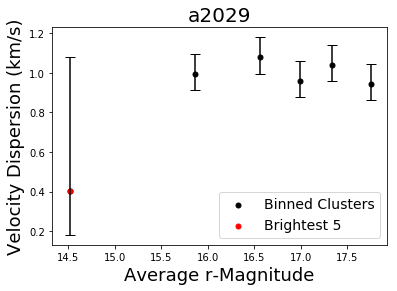

In [20]:
#another example, but using the whole PlotMyCluster
cz, ecz, g,r, dist,name=cluster(5)

plotMyCluster(5,r,cz,ecz,brightest=5)
plt.title(name)

Coma
a2069  Using a membership cut
a2069
a2219  Using a membership cut
a2219
rxj1720  Using a membership cut
rxj1720
a2029


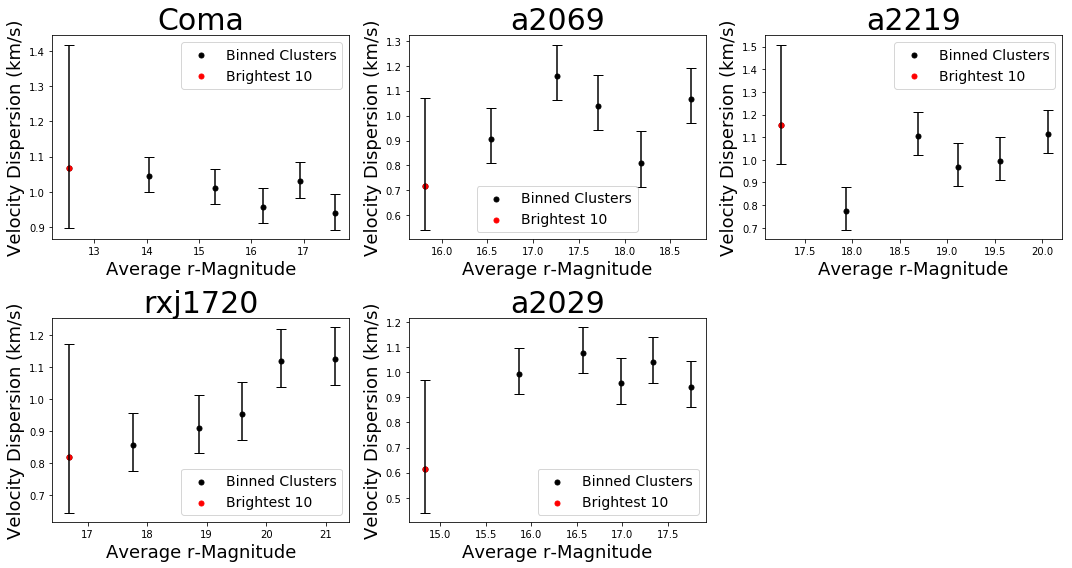

In [21]:
#plotting my whole data set of clusters

plt.figure(0,figsize=(15,8))
for i in range(1,6):
    plt.subplot(2,3,i)
    cz, ecz, g,r, dist,name=cluster(i)
    print(name)
    plotMyCluster(5,r,cz,ecz,brightest=10,tables=False)
    plt.title(name,fontsize=30)
    print('=======================================')

plt.tight_layout()



In [22]:
#Big list
finalList=np.zeros(12)
for i in range(1,6):
    cz, ecz, g,r, dist,name=cluster(i)
    
    disp=totalDis(r,cz,ecz,)[0]
    vbar=np.average(cz)
    vel1= (cz- vbar)/(1+vbar/c)
    rabs,g_r=restframe(cz,g,r)
    
    ai=vel1/disp[1]
    clai=np.sqrt((ecz/((1+vbar/c)*vel1))**2+((disp[2]+disp[3])/(2*disp[1]))**2)*ai
    
    new=np.column_stack([dist,np.repeat(name,len(vel1)),vel1,np.repeat(vbar/c,len(vel1)),ecz,np.repeat(disp[1],len(vel1)),np.repeat(disp[2],len(vel1)),np.repeat(disp[3],len(vel1)),rabs,g_r,ai,clai])
    finalList=np.row_stack([finalList,new])

finalList = np.delete(finalList, (0), axis=0)
#dists,names,delvs,zbars,eczs,dispclusters,downdisp,updisp,absmag,color,Ai,dispAi=finalList
finalData=pd.DataFrame(finalList,columns=['Dist','Cluster','\u0394v',r'$\bar{z}$','ecz','\u03C3 Cluster','\u0394\u03C3\u208B','\u0394\u03C3\u208A','Mr','g-r','Ai','\u03C3'+'Ai'])
display(finalData)

#display(pd.DataFrame(finalList,columns=['Dist','Cluster','\u0394v',r'$\bar{z}$','ecz','\u03C3 Cluster','\u0394\u03C3\u208B','\u0394\u03C3\u208A','Mr','g-r','Ai','\u03C3'+'Ai']))

a2069  Using a membership cut
a2219  Using a membership cut
rxj1720  Using a membership cut


,Dist,Cluster,Δv,$\bar{z}$,ecz,σ Cluster,Δσ₋,Δσ₊,Mr,g-r,Ai,σAi
0,0.024,Coma,600.2062667396875,0.02339251133786848,3.0,672.8645681055033,13.387645355403944,14.24185546890743,-20.690568108207213,0.8780631624353231,0.8920164550046227,0.01882526664911261
1,0.024,Coma,-172.7132057371389,0.02339251133786848,6.0,672.8645681055033,13.387645355403944,14.24185546890743,-17.11826065124289,0.6384022119655298,-0.25668346042268936,-0.010183043645053187
2,0.024,Coma,-631.9700351481483,0.02339251133786848,2.0,672.8645681055033,13.387645355403944,14.24185546890743,-19.96327113541563,0.753612254313841,-0.9392232331797521,-0.019500928839529273
3,0.029,Coma,-889.9355733705025,0.02339251133786848,14.0,672.8645681055033,13.387645355403944,14.24185546890743,-16.843333208207135,0.6812251535982543,-1.3226072757496767,-0.033922418911589126
4,0.029,Coma,-789.289927776175,0.02339251133786848,14.0,672.8645681055033,13.387645355403944,14.24185546890743,-16.51683321150681,0.11978389054228696,-1.1730294106561077,-0.031517866352693547
5,0.03,Coma,-558.684370880434,0.02339251133786848,3.0,672.8645681055033,13.387645355403944,14.24185546890743,-22.432050988175423,0.880746792474372,-0.8303073119951144,-0.01759513865493587
6,0.039,Coma,-673.0100071380683,0.02339251133786848,8.0,672.8645681055033,13.387645355403944,14.24185546890743,-16.532776191975028,0.10532114457864272,-1.0002161490431491,-0.023594180878219795
7,0.041,Coma,672.5147888171656,0.02339251133786848,2.0,672.8645681055033,13.387645355403944,14.24185546890743,-19.260014036581534,0.7529386183085622,0.9994801639067985,0.02072509956180211
8,0.042,Coma,244.52650949371431,0.02339251133786848,2.0,672.8645681055033,13.387645355403944,14.24185546890743,-18.544851056286287,0.7676687842377955,0.3634111841885145,0.008006651418554594
9,0.047,Coma,914.8460519957408,0.02339251133786848,15.0,672.8645681055033,13.387645355403944,14.24185546890743,-16.843531467522876,0.6658895774254159,1.359628809957334,0.0354082978541818


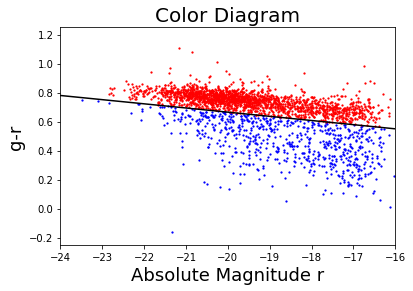

In [23]:
#Color Diagram
Mre=finalData['Mr'].astype(float)

color=finalData['g-r'].astype(float)

redindes=(color.astype(float)>(((Mre.astype(float)+16)*(.55-.78)/(-16+24)))+.55)

plt.scatter(Mre[~redindes].astype(float),color[~redindes].astype(float),s=1.5,c='b')
plt.scatter(Mre[redindes].astype(float),color[redindes].astype(float),s=1.5,c='r')
plt.ylim(-.25,1.25)
plt.xlim(-24,-16)
plt.title('Color Diagram')
plt.xlabel('Absolute Magnitude r')
plt.ylabel('g-r')

plt.plot([-24,-16],[.78,.55],c='k',linewidth=1.5)

Coma a2069
a2069 a2219
a2219 rxj1720
rxj1720 a2029
[   0 1175 1429 1772 2148 2515]
1175.0 Coma
254.0 a2069
343.0 a2219
376.0 rxj1720
367.0 a2029


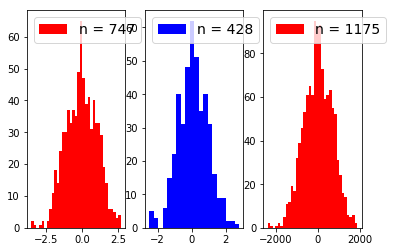

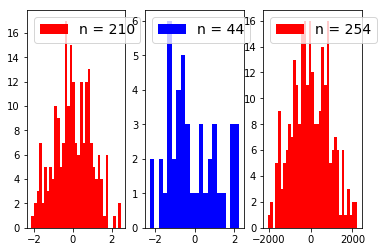

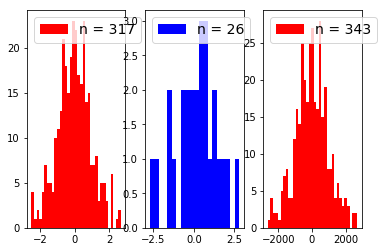

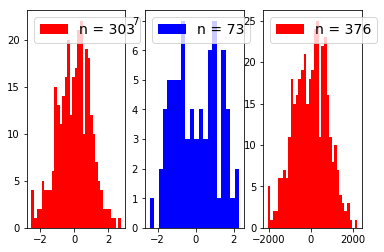

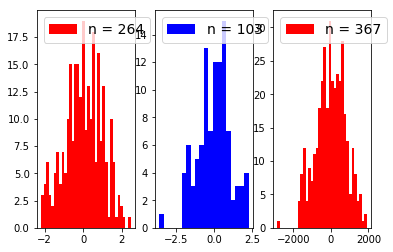

In [24]:
changes=np.where(np.array(finalData['Cluster'][:-1]) != np.array(finalData['Cluster'][1:]))[0]
for a in changes:
    
    print(finalData['Cluster'][a],finalData['Cluster'][a+1])


changes=np.append(np.array([0]),changes)
changes=np.append(changes,np.array([len(finalData)]))
print(changes)

for i in range(len(changes)-1):
    a=np.zeros(len(finalData))
    a[changes[i]:changes[i+1]]=1
    print(sum(a),finalData['Cluster'][changes[i]+1])
    b=np.logical_and(a,redindes)
    c=np.logical_and(a,~redindes)
    plt.figure(i)
    plt.title(finalData['Cluster'][changes[i]])
    plt.subplot(131)
    plt.hist(finalData['Ai'][b].astype(float),bins=35,color='r')
    plt.legend(['n = '+str(len(finalData['Ai'][b]))],loc=2)
    plt.subplot(132)
    plt.hist(finalData['Ai'][c].astype(float),bins=20,color='b')
    plt.legend(['n = '+str(len(finalData['Ai'][c]))],loc=2)
    plt.subplot(133)
    plt.hist(finalData['\u0394v'][changes[i]:changes[i+1]].astype(float),bins=35,color='r')
    plt.legend(['n = '+str(len(finalData['\u0394v'][changes[i]:changes[i+1]]))],loc=2)

# i=3
# a=np.zeros(len(finalData))
# a[changes[i]:changes[i+1]]=1
# print(sum(a))
# b=np.logical_and(a,redindes)
# c=np.logical_and(a,~redindes)
# plt.figure(i)
# plt.hist(finalData['Ai'][b].astype(float),bins=35,color='r')
# plt.hist(finalData['Ai'][c].astype(float),bins=35,color='b')

Text(0,0.5,'N  ')

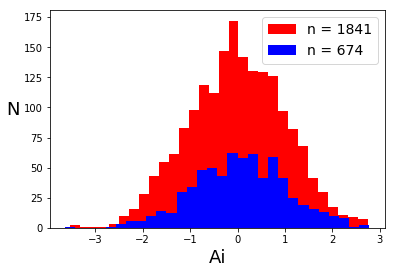

In [25]:
plt.hist(finalData['Ai'][redindes].astype(float),bins=30,color='r',label='n = '+str(len(finalData['Ai'][redindes])))
plt.hist(finalData['Ai'][~redindes].astype(float),bins=30,color='b',label='n = '+str(len(finalData['Ai'][~redindes])))
plt.legend()
plt.xlabel('Ai')
plt.ylabel('N  ',rotation=0)

C:\Users\Erick\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  if __name__ == '__main__':
C:\Users\Erick\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  del sys.path[0]


Red Galaxies:
Mean: -0.01889128267208178  Width: 1.0048820695917156 

Blue Galaxies
Mean: 0.051600669731900736  Width: 0.9832171397356406


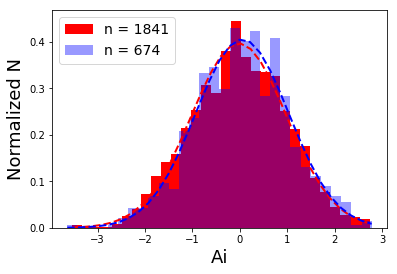

In [26]:
n1, bins1, patches1 = plt.hist(finalData['Ai'][redindes].astype(float),bins=30,color='r',density=True,label='n = '+str(len(finalData['Ai'][redindes])))
n2, bins2, patches2 = plt.hist(finalData['Ai'][~redindes].astype(float),bins=30,color='b',alpha=.4,density=True,label='n = '+str(len(finalData['Ai'][~redindes])))
plt.legend()
plt.xlabel('Ai')
plt.ylabel('Normalized N')


(mu1, sigma1) = norm.fit(finalData['Ai'][redindes].astype(float))
y1 = mlab.normpdf( bins1, mu1, sigma1)
l1 = plt.plot(bins1, y1, 'r--', linewidth=2)

(mu2, sigma2) = norm.fit(finalData['Ai'][~redindes].astype(float))
y2 = mlab.normpdf( bins2, mu2, sigma2)
l2 = plt.plot(bins2, y2, 'b--', linewidth=2)
print('Red Galaxies:\nMean:',mu1,' Width:',sigma1,'\n\nBlue Galaxies\nMean:',mu2,' Width:',sigma2)

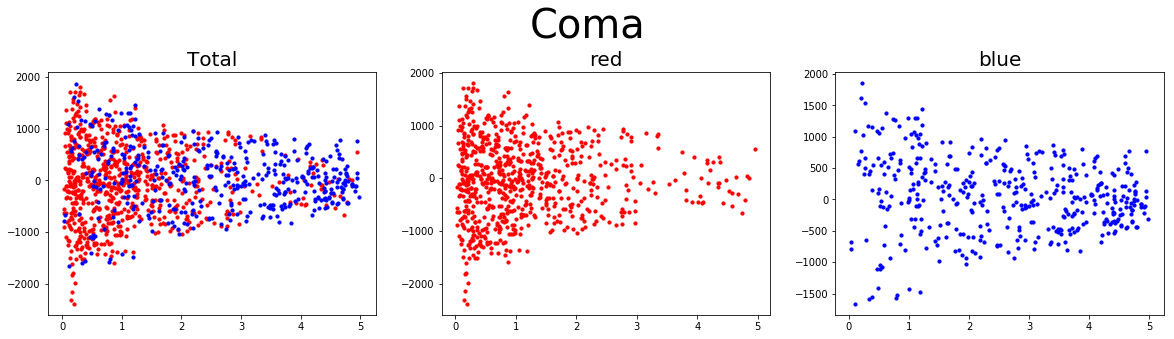

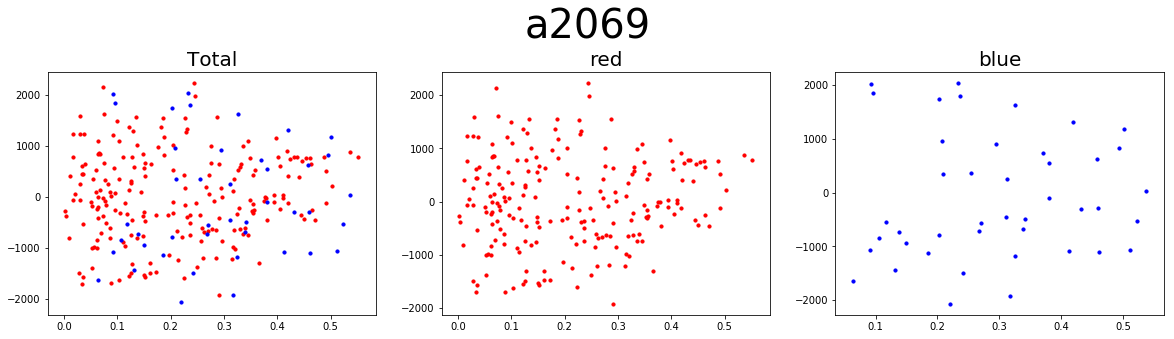

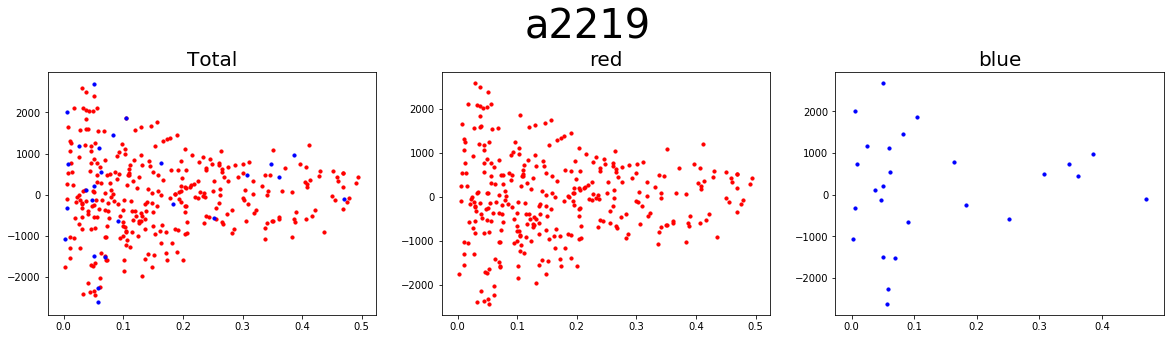

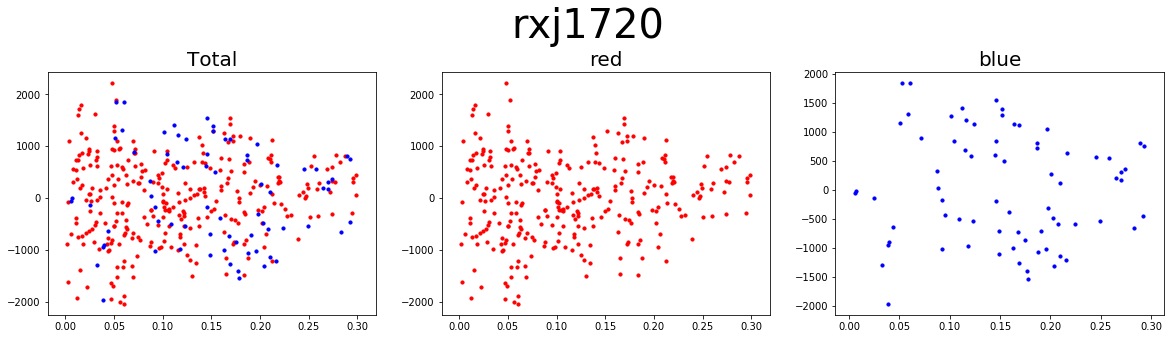

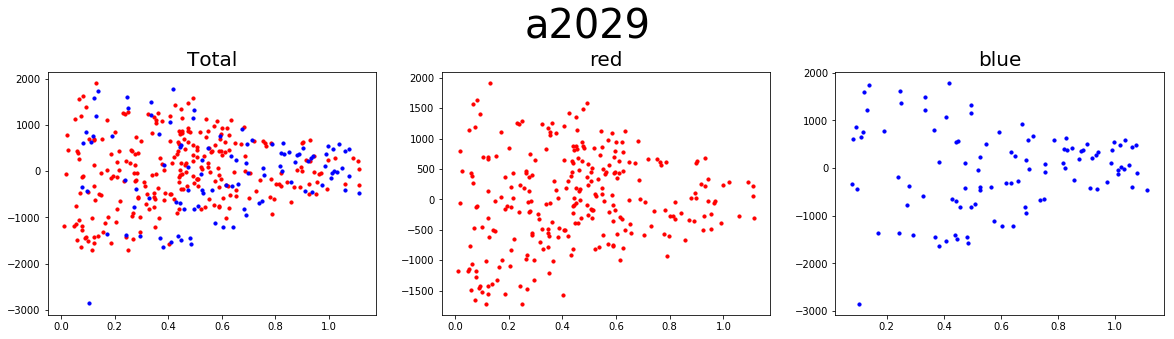

In [106]:
for i in range(len(changes)-1):
        
    a=np.zeros(len(finalData))
    a[changes[i]+1:changes[i+1]+1]=1
    a=[bool(x) for x in a]
    b=np.logical_and(a,redindes)
    c=np.logical_and(a,~redindes)
    
    angdist=np.array(finalData[a]['Dist'].astype(float))
    cosmoz=np.array(finalData[a][r'$\bar{z}$'].astype(float))
    listy=angdist*cosmo.angular_diameter_distance(cosmoz)
        
    plt.figure(i,figsize=(20,5))
    plt.suptitle(finalData['Cluster'][changes[i]+1], fontsize=40)
    plt.tight_layout()
    
    plt.subplot(131)
    plt.scatter(finalData['Dist'][b].astype(float),finalData['\u0394v'][b].astype(float),s=10,c='r')
    plt.scatter(finalData['Dist'][c].astype(float),finalData['\u0394v'][c].astype(float),s=10,c='b')
    plt.title('Total')
    
    plt.subplot(132)
    plt.scatter(finalData['Dist'][b].astype(float),finalData['\u0394v'][b].astype(float),s=10,c='r')
    plt.title('red')
    
    plt.subplot(133)
    plt.scatter(finalData['Dist'][c].astype(float),finalData['\u0394v'][c].astype(float),s=10,c='b')
    plt.title('blue')
    plt.subplots_adjust(top=.8)
    

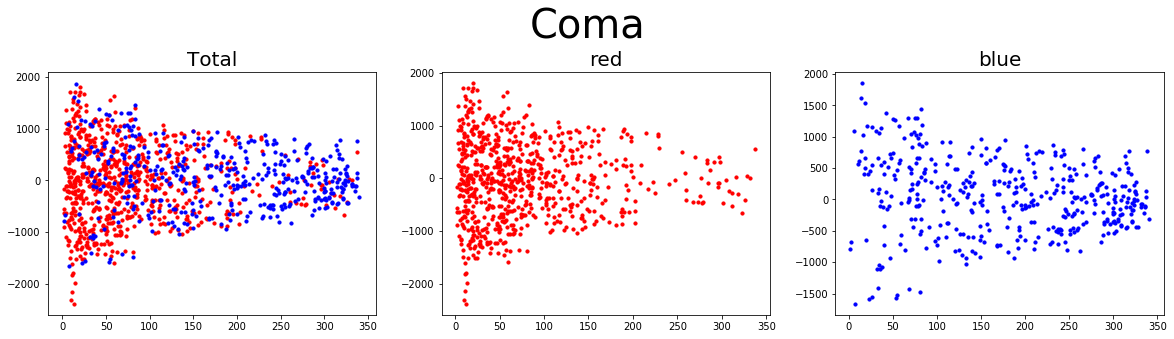

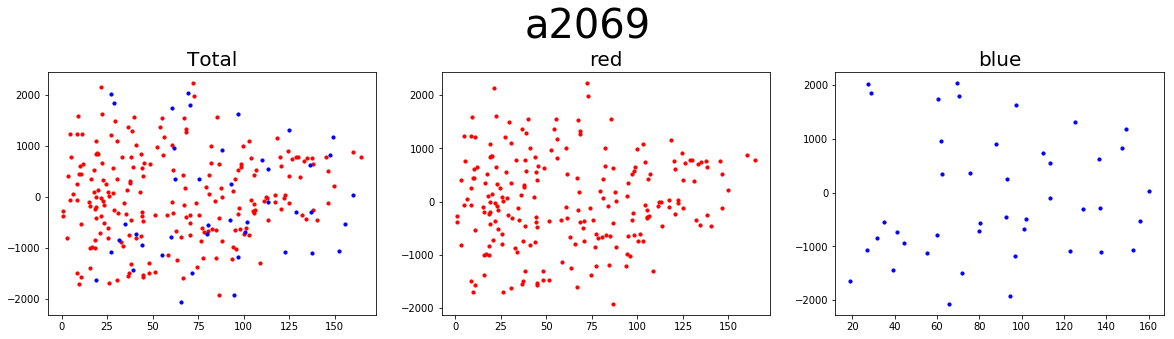

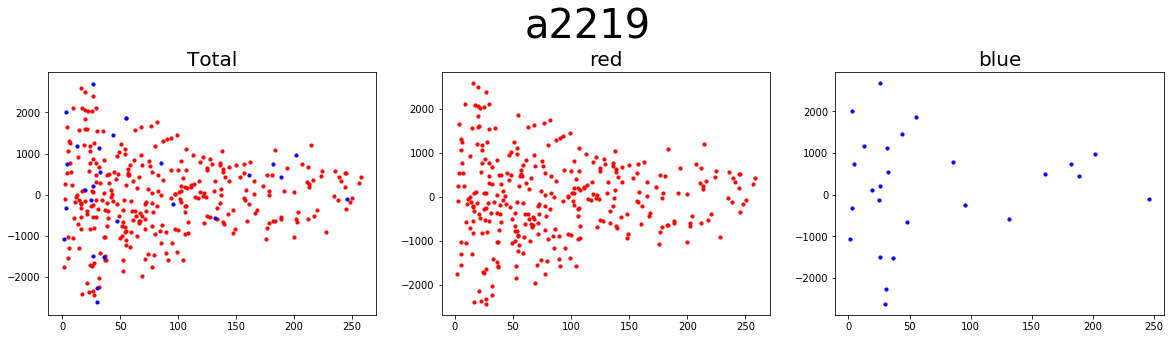

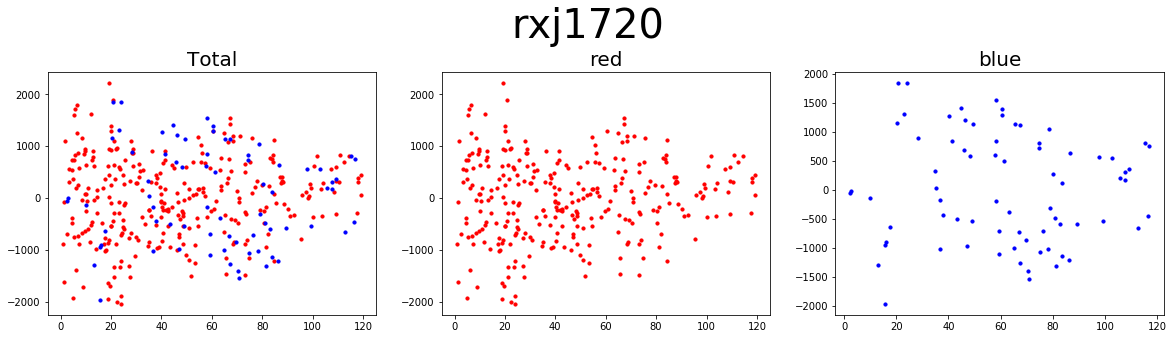

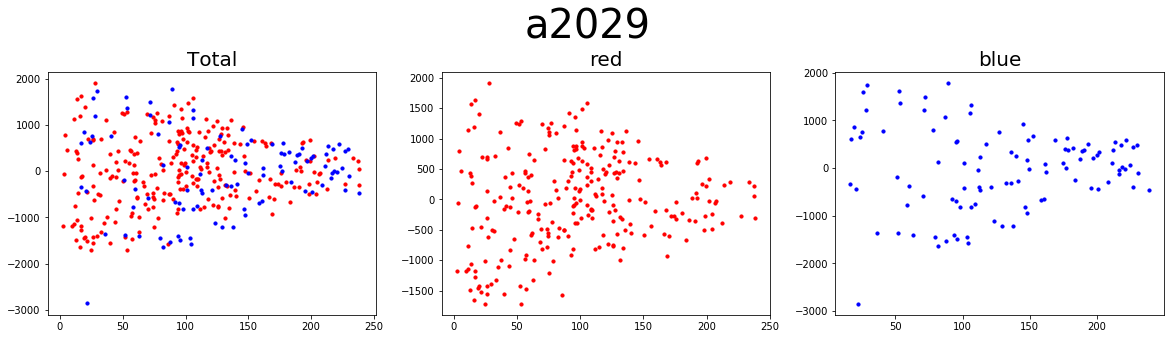

In [113]:
angdist=np.array(finalData['Dist'].astype(float))
cosmoz=np.array(finalData[r'$\bar{z}$'].astype(float))
listy=angdist*cosmo.angular_diameter_distance(cosmoz)

for i in range(len(changes)-1):
        
    a=np.zeros(len(finalData))
    a[changes[i]+1:changes[i+1]+1]=1
    a=[bool(x) for x in a]
    b=np.logical_and(a,redindes)
    c=np.logical_and(a,~redindes)
        
    plt.figure(i,figsize=(20,5))
    plt.suptitle(finalData['Cluster'][changes[i]+1], fontsize=40)
    plt.tight_layout()
    
    plt.subplot(131)
    plt.scatter(listy[b],finalData['\u0394v'][b].astype(float),s=10,c='r')
    plt.scatter(listy[c],finalData['\u0394v'][c].astype(float),s=10,c='b')
    plt.title('Total')
    
    plt.subplot(132)
    plt.scatter(listy[b],finalData['\u0394v'][b].astype(float),s=10,c='r')
    plt.title('red')
    
    plt.subplot(133)
    plt.scatter(listy[c],finalData['\u0394v'][c].astype(float),s=10,c='b')
    plt.title('blue')
    plt.subplots_adjust(top=.8)
    

In [148]:
print(finalData['Dist'][changes[0]:changes[1]])

ra,dec= np.loadtxt(os.getcwd()+"\Data\comaallzad.tab.010.q25mem.tab", usecols=(0,1),skiprows=2, unpack=True)

c1=SkyCoord(np.median(ra),np.median(dec),unit=('deg'))
c2=SkyCoord(ra,dec,unit=('deg'))
sep=c1.separation(c2)
dist=sep.deg
print(dist)


cosmoz=float(finalData[r'$\bar{z}$'][0])
listy=dist*cosmo.angular_diameter_distance(cosmoz)
print(listy)

0       0.024
1       0.024
2       0.024
3       0.029
4       0.029
5        0.03
6       0.039
7       0.041
8       0.042
9       0.047
10      0.054
11      0.058
12       0.06
13      0.066
14      0.067
15      0.067
16      0.068
17      0.073
18      0.077
19      0.079
20       0.08
21      0.081
22      0.082
23       0.09
24      0.091
25      0.096
26      0.097
27      0.098
28      0.098
29        0.1
        ...  
1145    4.706
1146    4.707
1147    4.715
1148    4.719
1149    4.721
1150     4.73
1151    4.744
1152    4.749
1153    4.751
1154    4.752
1155    4.758
1156    4.769
1157    4.773
1158    4.779
1159     4.78
1160    4.781
1161    4.797
1162    4.803
1163    4.822
1164    4.858
1165    4.862
1166    4.863
1167    4.872
1168    4.918
1169    4.921
1170    4.924
1171    4.942
1172    4.946
1173    4.946
1174    4.956
Name: Dist, Length: 1175, dtype: object
[0.22163932 0.20199887 0.2166664  ... 4.98208396 4.76345897 4.83389707]
[ 15.10772035  13.76895765  14.768